In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
gwic_filename = '../data/missoula_valley_monitored_wells.csv'
usgs_filename = '../data/clark_fk_above_missoula_q.csv'
gw_df = pd.read_csv(gwic_filename, index_col='time', parse_dates=True)
q_df = pd.read_csv(usgs_filename, index_col='time', parse_dates=True)

In [3]:
df = pd.concat([q_df, gw_df], axis=1, join='inner')

## Data Imputation

### Linear interpolation

In [34]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    lin_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = lin_imputed.iloc[:, c].first_valid_index()
        new_df = lin_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Linear interpolation
        new_df_int = new_df.interpolate(method='linear')
        new_df_int_ind = new_df_int.index

        # Update dataframe
        lin_imputed.iloc[:, c][new_df_int_ind] = new_df_int

        # Aggregate test data
        test_data = pd.concat([test_values, new_df_int[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            lin_test_data = test_data
        else:
            lin_test_data = pd.concat([lin_test_data, test_data], axis=0)

In [35]:
# Calculate error statistics
lin_mae = mean_absolute_error(lin_test_data['value'], lin_test_data['estimate'])
lin_mse = mean_squared_error(lin_test_data['value'], lin_test_data['estimate'])
lin_rmse = np.sqrt(lin_mse)
lin_mape = np.mean(np.abs((lin_test_data['value'] - lin_test_data['estimate']) / lin_test_data['value'])) * 100
lin_rsquared = r2_score(lin_test_data['value'], lin_test_data['estimate'])

lin_error_stats = pd.DataFrame({
    'MAE': lin_mae,
    'MSE': lin_mse,
    'RMSE': lin_rmse,
    'MAPE': lin_mape,
    'R^2': lin_rsquared
}, index=['Linear Interpolation'])

lin_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.383803,13.563392,3.682851,10.053654,0.962328


<Axes: xlabel='value', ylabel='estimate'>

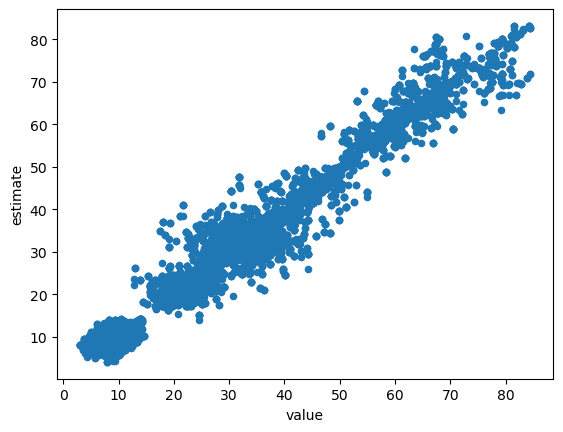

In [36]:
lin_test_data.plot.scatter(x='value', y='estimate')

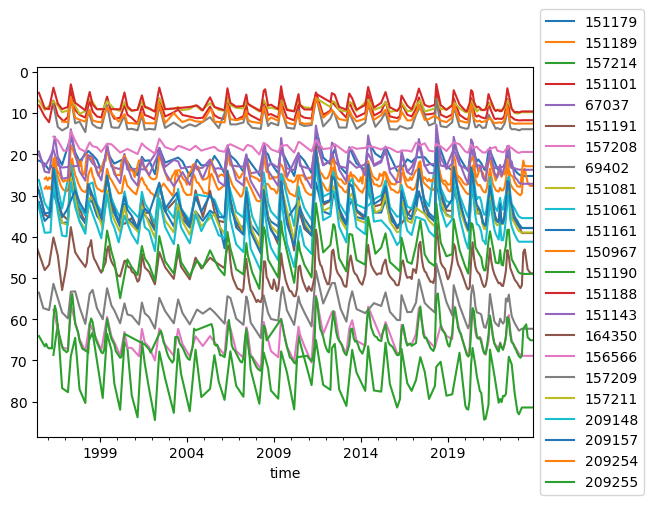

In [37]:
ax = lin_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Interpolate with time

In [ ]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    time_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = time_imputed.iloc[:, c].first_valid_index()
        new_df = time_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Linear interpolation
        new_df_int = new_df.interpolate(method='time')
        new_df_int_ind = new_df_int.index

        # Update dataframe
        time_imputed.iloc[:, c][new_df_int_ind] = new_df_int

        # Aggregate test data
        test_data = pd.concat([test_values, new_df_int[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            time_test_data = test_data
        else:
            time_test_data = pd.concat([time_test_data, test_data], axis=0)

In [ ]:
# Calculate error statistics
time_mae = mean_absolute_error(time_test_data['value'], time_test_data['estimate'])
time_mse = mean_squared_error(time_test_data['value'], time_test_data['estimate'])
time_rmse = np.sqrt(time_mse)
time_mape = np.mean(np.abs((time_test_data['value'] - time_test_data['estimate']) / time_test_data['value'])) * 100
time_rsquared = r2_score(time_test_data['value'], time_test_data['estimate'])

time_error_stats = pd.DataFrame({
    'MAE': time_mae,
    'MSE': time_mse,
    'RMSE': time_rmse,
    'MAPE': time_mape,
    'R^2': time_rsquared
}, index=['Time Interpolation'])

time_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Time Interpolation,2.366791,13.353738,3.654277,10.118949,0.962984


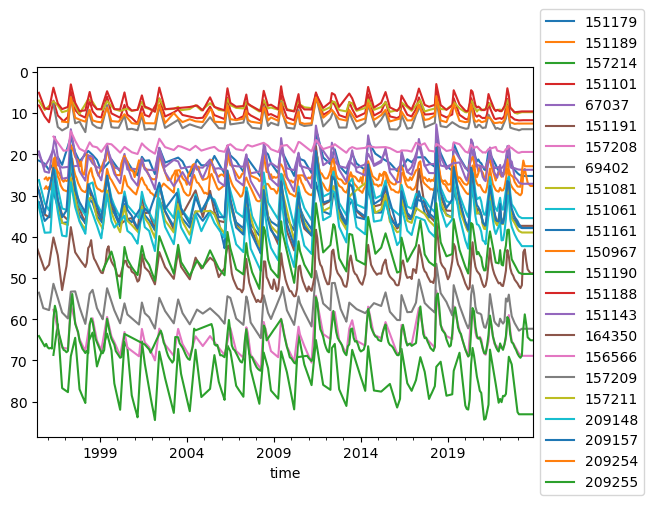

In [39]:
ax = time_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Seasonal Trend Decomposition using Loess (STL)
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [9]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    stl_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):
        
        # Drop preceding NaNs
        first_ind = stl_imputed.iloc[:, c].first_valid_index()
        new_df = stl_imputed.iloc[:, c][first_ind:]
        
        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.isna().index

        # Need to interpolate because STL doesn't handle NaNs
        new_df = new_df.ffill()

        # Apply STL decomposition to the groundwater level data
        stl = STL(new_df, seasonal=7, period=12, robust=True)
        res = stl.fit()

        # Extract the seasonal component
        seasonal = res.seasonal
        
        # Created deseasonalized groundwater level data
        df_deseas = new_df - seasonal

        # Interpolate the deseasonalized data
        df_deseas_int = df_deseas.interpolate(method='linear')

        # Add seasonal component back to deseasonalized data
        df_imputed = df_deseas_int + seasonal
        
        # Replace NaNs with imputed data
        stl_imputed.iloc[:, c][imputed_indices] = df_imputed[imputed_indices]
        
        # Aggregate test data
        test_data = pd.concat([test_values, df_imputed[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            stl_test_data = test_data
        else:
            stl_test_data = pd.concat([stl_test_data, test_data], axis=0)

In [10]:
# Calculate error statistics
stl_mae = mean_absolute_error(stl_test_data['value'], stl_test_data['estimate'])
stl_mse = mean_squared_error(stl_test_data['value'], stl_test_data['estimate'])
stl_rmse = np.sqrt(stl_mse)
stl_mape = np.mean(np.abs((stl_test_data['value'] - stl_test_data['estimate']) / stl_test_data['value'])) * 100
stl_rsquared = r2_score(stl_test_data['value'], stl_test_data['estimate'])
stl_mape

stl_error_stats = pd.DataFrame({
    'MAE': stl_mae,
    'MSE': stl_mse,
    'RMSE': stl_rmse,
    'MAPE': stl_mape,
    'R^2': stl_rsquared
}, index=['STL Decomposition'])

stl_error_stats


,MAE,MSE,RMSE,MAPE,R^2
STL Decomposition,2.980633,18.984721,4.357146,12.576928,0.947537


<Axes: xlabel='time'>

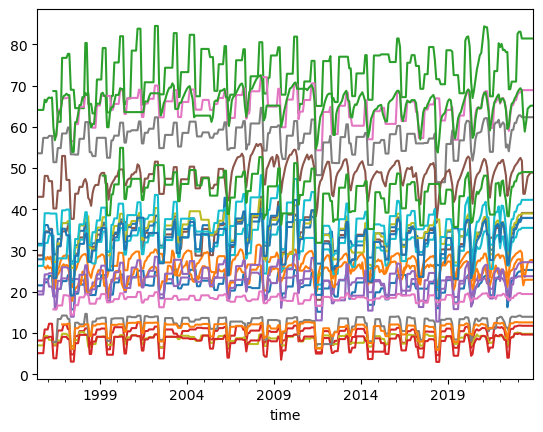

In [11]:
# Plot
stl_imputed.iloc[:, 1:].plot(legend=False)

## Regression imputation using Q and DOY 
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [66]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    reg_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = df.iloc[:, c].first_valid_index()
        new_df = df.iloc[:, [0, c]][first_ind:]  
            
        # Pull out 5 random points for test data
        values_indices = new_df.iloc[:, [0, 1]].dropna().index
        test_indices = np.random.choice(values_indices, 5, replace=False)
        test_values = new_df.iloc[:, 1][test_indices]
        new_df.iloc[:, 1].loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.iloc[:, 1][new_df.iloc[:, 1].isnull()].index

        # Drop rows with missing values
        df_dropped = new_df.iloc[:, [0, 1]].dropna()    

        # Get predictors (Q and doy) and dependent variable
        X = np.column_stack((df_dropped.Q.values, df_dropped.index.dayofyear.values))
        Y = df_dropped.iloc[:, 1].values

        # Instantiate model
        model = LinearRegression()

        # Fit model
        model.fit(X, Y)

        # Predict missing values
        pred1 = new_df.loc[imputed_indices, 'Q'].values
        pred2 = new_df.loc[imputed_indices, 'Q'].index.dayofyear.values
        preds = np.column_stack((pred1, pred2))
        predicted = model.predict(preds)
        
        # Fill missing values with predicted values
        reg_imputed.iloc[:, c][imputed_indices] = predicted

        # Aggregate test data
        test_data = pd.concat([test_values, reg_imputed.iloc[:, c][test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            reg_test_data = test_data
        else:
            reg_test_data = pd.concat([reg_test_data, test_data], axis=0)

<Axes: xlabel='value', ylabel='estimate'>

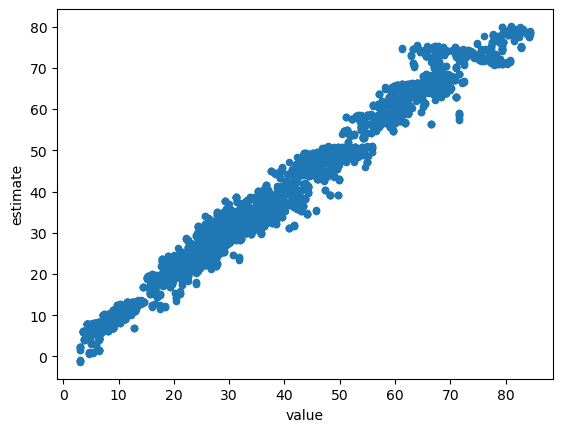

In [88]:
reg_test_data.plot.scatter(x='value', y='estimate')

In [67]:
# Calculate error statistics
reg_mae = mean_absolute_error(reg_test_data['value'], reg_test_data['estimate'])
reg_mse = mean_squared_error(reg_test_data['value'], reg_test_data['estimate'])
reg_rmse = np.sqrt(reg_mse)
reg_mape = np.mean(np.abs((reg_test_data['value'] - reg_test_data['estimate']) / reg_test_data['value'])) * 100
reg_rsquared = r2_score(reg_test_data['value'], reg_test_data['estimate'])
reg_mape

reg_error_stats = pd.DataFrame({
    'MAE': reg_mae,
    'MSE': reg_mse,
    'RMSE': reg_rmse,
    'MAPE': reg_mape,
    'R^2': reg_rsquared
}, index=['Q and DOY Regression'])

reg_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Q and DOY Regression,1.661258,5.689708,2.385311,6.148374,0.984241


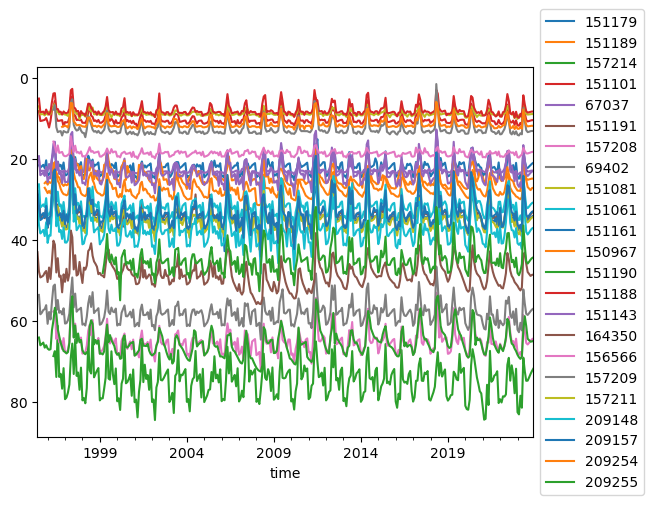

In [68]:
ax = reg_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Regression with surrounding points and doy

In [69]:
for i in range(100):

    # Make sure dataset is clean each time
    reg2_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):
    
        # Drop preceding NaNs
        first_ind = reg2_imputed.iloc[:, c].first_valid_index()
        new_df = reg2_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df[new_df.isna()].index[:-1]

        # Linear interpolation
        new_df_int = new_df.interpolate(method='time')
        new_df_int_ind = new_df_int.index

        # Create predictors for mlr
        pred_pos = new_df_int.shift(1).iloc[1:-1]
        pred_neg = new_df_int.shift(-1).iloc[1:-1]
        df_y = new_df_int[pred_pos.index][pred_neg.index]
        pred_doys = pred_pos.index.dayofyear

        # Get predictors (Q and doy) and dependent variable
        X = np.column_stack((pred_pos.values, pred_neg.values, pred_doys.values))
        Y = df_y.values

        # Instantiate model
        model = LinearRegression()

        # Fit model
        model.fit(X, Y)

        # Predict missing values
        pred1 = pred_pos.loc[imputed_indices].values
        pred2 = pred_neg.loc[imputed_indices].values
        pred3 = imputed_indices.dayofyear.values
        preds = np.column_stack((pred1, pred2, pred3))
        predicted = model.predict(preds)

        # Fill missing values with predicted values
        reg2_imputed.iloc[:, c][imputed_indices] = predicted

        # Aggregate test data
        test_data = pd.concat([test_values, reg2_imputed.iloc[:, c][test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            reg2_test_data = test_data
        else:
            reg2_test_data = pd.concat([reg2_test_data, test_data], axis=0)

<Axes: xlabel='value', ylabel='estimate'>

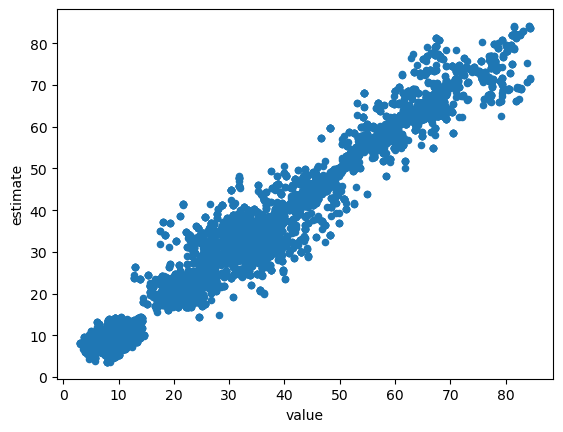

In [87]:
reg2_test_data.plot.scatter(x='value', y='estimate')


In [73]:
# Calculate error statistics
reg2_mae = mean_absolute_error(reg2_test_data['value'], reg2_test_data['estimate'])
reg2_mse = mean_squared_error(reg2_test_data['value'], reg2_test_data['estimate'])
reg2_rmse = np.sqrt(reg2_mse)
reg2_mape = np.mean(np.abs((reg2_test_data['value'] - reg2_test_data['estimate']) / reg2_test_data['value'])) * 100
reg2_rsquared = r2_score(reg2_test_data['value'], reg2_test_data['estimate'])

reg2_error_stats = pd.DataFrame({
    'MAE': reg2_mae,
    'MSE': reg2_mse,
    'RMSE': reg2_rmse,
    'MAPE': reg2_mape,
    'R^2': reg2_rsquared
}, index=['Time interp. with Regression'])

reg2_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Time interp. with Regression,2.463659,14.654192,3.828079,10.285285,0.959318


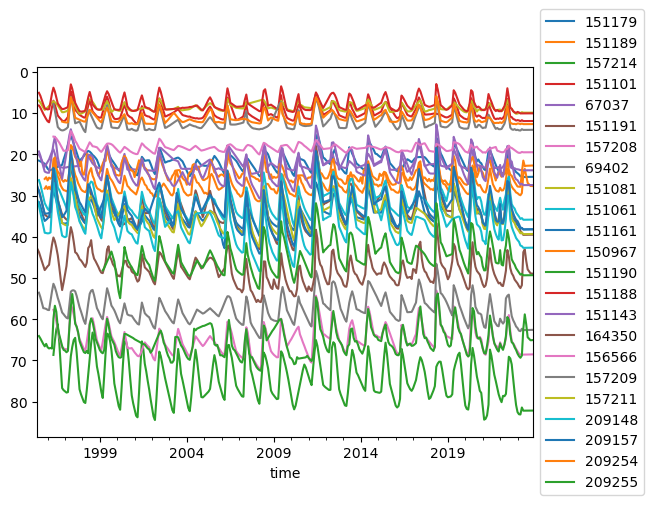

In [75]:
ax = reg2_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

In [74]:
pd.concat([lin_error_stats, 
           stl_error_stats, 
           time_error_stats, 
           reg_error_stats, 
           reg2_error_stats], 
          axis=0)

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.383803,13.563392,3.682851,10.053654,0.962328
STL Decomposition,2.980633,18.984721,4.357146,12.576928,0.947537
Time Interpolation,2.366791,13.353738,3.654277,10.118949,0.962984
Q and DOY Regression,1.661258,5.689708,2.385311,6.148374,0.984241
Time interp. with Regression,2.463659,14.654192,3.828079,10.285285,0.959318
